In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
from keras.engine import data_adapter
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v6 import Autoencoder
from tools.GRU_AR_v6 import AR_RNN_GRU as AR_RNN
# from tools.LSTM_AR_v2 import AR_RNN_LSTM as AR_RNN
from tools.AEGRU_AR_v1 import AR_AERNN_GRU
from tools.trainAERNN import trainAERNN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpoin?tAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-01-23 22:23:06.818197: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 22:23:06.818690: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 22:23:06.861724: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 22:23:06.862072: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 22:23:06.862368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_065'

    # making AR-RNN save directory
    dir_name_ARrnn = os.getcwd() + dir_sep + 'saved_AR_AERNN_rnn'
    if not os.path.isdir(dir_name_ARrnn):
        os.makedirs(dir_name_ARrnn)

    counter = 0
    while True:
        dir_check = 'AR_rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ARrnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ARrnn = dir_name_ARrnn + dir_sep + dir_check
    os.makedirs(dir_name_ARrnn)
    os.makedirs(dir_name_ARrnn+dir_sep+'plots')
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    try:
        dense_layer_act_func = params_rnn_dict['dense_layer_act_func']
    except:
        print("'dense_layer_act_func' not present in RNN_specific_data, set to 'linear'.")
        dense_layer_act_func = 'linear'
    try:
        stateful = params_rnn_dict['stateful']
    except:
        print("'stateful' not present in RNN_specific_data, set to True.")
        stateful = True
    try:
        use_learnable_state = params_rnn_dict['use_learnable_state']
    except:
        print("'use_learnable_state' not present in RNN_specific_data, set to False.")
        use_learnable_state = False
    try:
        use_weights_post_dense = params_rnn_dict['use_weights_post_dense']
    except:
        print("'use_weights_post_dense' not present in RNN_specific_data, set to False.")
        use_weights_post_dense = False
        
    
    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0

    loss_weights = 0.98
else:
    # AR-RNN directory
    dir_name_ARrnn = os.getcwd()+'/saved_AR_AERNN_rnn/AR_AErnn_000'

    # reading AR-RNN parameters
    with open(dir_name_ARrnn + '/AR_rnn_specific_data.txt') as f:
        lines = f.readlines()
    
    params_AR_rnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_rnn_dict['dir_name_rnn']
    rnn_idx = dir_name_rnn[-3:]
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_'+rnn_idx

    dt_rnn = params_AR_rnn_dict['dt_rnn']
    T_sample_input = params_AR_rnn_dict['T_sample_input']
    T_sample_output = params_AR_rnn_dict['T_sample_output']
    T_offset = params_AR_rnn_dict['T_offset']
    return_params_arr = params_AR_rnn_dict['return_params_arr']
    params = params_AR_rnn_dict['params']
    try:
        normalize_dataset = params_AR_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_AR_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_AR_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        use_ae_data = params_AR_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True

    # training params
    with open(dir_name_ARrnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0
    try:
        loss_weights = tparams_dict['loss_weights']
    except:
        loss_weights = None
    if 'freeze_layers' in tparams_dict.keys():
        freeze_layers = tparams_dict['freeze_layers']
    else:
        freeze_layers = None
    if 'clipnorm' in tparams_dict.keys():
        clipnorm = tparams_dict['clipnorm']
    else:
        clipnorm = None
    


# reading stddev
with open(dir_name_rnn + '/final_net/final_net_class_dict.txt') as f:
    lines = f.readlines()
finalnet_dict = eval(''.join(lines))
stddev = finalnet_dict['stddev']
# stddev = 0.0

# reading RNN normalization constants
normalization_arr_rnn = None
if normalize_dataset == True:
    with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
        lines = f.readlines()
    normarr_rnn_dict = eval(''.join(lines))
    normalization_arr_rnn = normarr_rnn_dict['normalization_arr']

if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_arr_rnn = fl['normalization_arr'][0]

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx
try:
    use_ae_data = params_dict['use_ae_data']
except:
    print("'use_ae_data' not present in sim_data_AE_params, set to True.")
    use_ae_data = True

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in RNN_specific_data, set to True.")
    ae_data_with_params = True

print('dir_name_AR_AErnn:', dir_name_ARrnn)
print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state_mat = params_dict['init_state_mat']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']
    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']


test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

dir_name_AR_AErnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_065
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_043
data_dir_idx: 005
normalize_flag_ogdata: False


In [12]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [13]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

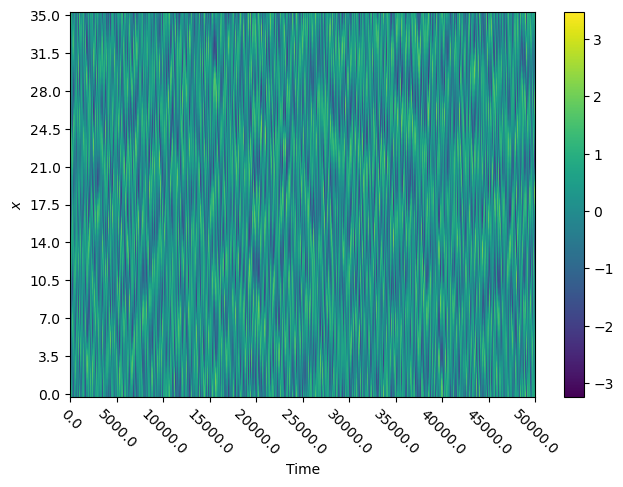

In [14]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [15]:
# # dealing with normalizing the data before feeding into autoencoder
# if use_ae_data == True:
#     if normalizeforae_flag == True:
#         for i in range(numpoints_xgrid):
#             all_data[:, i] -= normalization_constant_arr_aedata[0, i]
#             all_data[:, i] /= normalization_constant_arr_aedata[1, i]

#     if ae_data_with_params == False:
#         all_data = all_data[:, 0:numpoints_xgrid]
# else:
#     # using raw data, neglecting the params attached (if any)
#     all_data = all_data[:, 0:numpoints_xgrid]

if use_ae_data == True and ae_data_with_params == False:
    all_data = all_data[:, 0:numpoints_xgrid]
else:
    all_data = all_data[:, 0:numpoints_xgrid]

# Autoencoder

In [16]:
# if use_ae_data == True:
#     load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
#     wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [17]:
# if use_ae_data == True:
#     ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
#     ae_net.load_weights_from_file(wt_file)

# GRU

In [18]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = np.array([
#         5, 
        10,
        30,
        50,
#         70
    ])*dt_rnn/np.mean(lyapunov_time_arr)
    num_timesteps_warmup = 1*np.mean(lyapunov_time_arr)/dt_rnn
    T_sample_input = num_timesteps_warmup*dt_rnn
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = T_sample_input
    skip_intermediate = 'full sample'
    stateful = True
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving AR RNN specific data
    AR_RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'num_timesteps_warmup':num_timesteps_warmup,
        'dir_name_rnn':dir_name_rnn,
        'dir_name_ae':dir_name_ae,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':AR_RNN.__module__,
        'normalization_type':normalization_type,
        'use_ae_data':use_ae_data,
        'stateful':stateful,
    }

    with open(dir_name_ARrnn+dir_sep+'AR_RNN_specific_data.txt', 'w') as f:
        f.write(str(AR_RNN_specific_data))

In [19]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [
#         [5e-5],
        [5e-5],
        [1e-5],
        [1e-6],
#         [5e-7],
    ]
    epochs = [
#         [1000],
        [1000],
        [1000],
        [1000],
#         [1000],
    ]
    patience = [
#         [30],
        [30],
        [30],
        [50],
#         [50],
    ] # parameter for early stopping
    min_delta = 1e-5  # parameter for early stopping
    lambda_reg = 5e-7  # weight for regularizer
    covmat_lmda = 1e-5  # weight for the covmat loss

    if loss_weights is None:
        loss_weights = 1.0
        
    freeze_layers = [
        [],
        [],
        [],
        [],
        [],
    ]
    
    clipnorm = None #1.0
    batch_size = [
#         32,
        32,
        32,
        16,
#         32,
    ]
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'loss_weights':loss_weights,
        'stddev':stddev,
        'covmat_lmda':covmat_lmda,
        'freeze_layers':freeze_layers,
        'clipnorm':clipnorm,
    }

    with open(dir_name_ARrnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_ARrnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr_rnn],
    )

In [20]:
if behaviour == 'initialiseAndTrainFromScratch':
    load_file_rnn = dir_name_rnn + '/final_net/final_net_class_dict.txt'
    wt_file_rnn = dir_name_rnn+'/final_net/final_net_gru_weights.h5'
    
    load_file_ae = dir_name_ae+'/final_net/final_net_class_dict.txt'
    wt_file_ae = dir_name_ae+'/final_net/final_net_ae_weights.h5'



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 10 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : None


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 5e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
71/71 [==============================] - ETA: 0s - loss: 0.0092 - mse: 0.0012 - NMSE: 0.0104 - covmat_fro_loss: 6.7676e-04 - global_gradnorm: 0.7525 - tot_time: 0h 0m 51.7s

Epoch 1: val_NMSE improved from inf to 0.00593, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoi

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 23s 330ms/step - loss: 0.0039 - mse: 4.6785e-04 - NMSE: 0.0042 - covmat_fro_loss: 4.5591e-04 - global_gradnorm: 0.4515 - val_loss: 0.0037 - val_mse: 4.4594e-04 - val_NMSE: 0.0040 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/1000
71/71 [==============================] - ETA: 0s - loss: 0.0036 - mse: 4.3228e-04 - NMSE: 0.0039 - covmat_fro_loss: 4.3925e-04 - global_gradnorm: 0.4219 - tot_time: 0h 5m 6.8s

Epoch 12: val_NMSE did not improve from 0.00401
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 23s 323ms/step - loss: 0.0036 - mse: 4.3228e-04 - NMSE: 0.0039 - covmat_fro_loss: 4.3943e-04 - global_gradnorm: 0.4224 - val_loss: 0.0039 

Epoch 23/1000
71/71 [==============================] - ETA: 0s - loss: 0.0029 - mse: 3.4690e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9557e-04 - global_gradnorm: 0.3545 - tot_time: 0h 9m 19.1s

Epoch 23: val_NMSE improved from 0.00331 to 0.00308, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 24s 343ms/step - loss: 0.0029 - mse: 3.4690e-04 - NMSE: 0.0031 - covmat_fro_loss: 3.9541e-04 - global_gradnorm: 0.3547 - val_loss: 0.0029 - val_mse: 3.4236e-04 - val_NMSE: 0.0031 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 24/1000
71/71 [==============================] - ETA: 0s - loss: 0.0032 - mse: 3.7890e-04 - NMSE: 0.0034 - covmat_fro_loss: 4.1309e-04 - global_gradnorm: 0.3826 - tot_time: 0h 9m 43.5s

Epoch 

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 23s 329ms/step - loss: 0.0026 - mse: 3.0183e-04 - NMSE: 0.0027 - covmat_fro_loss: 3.7221e-04 - global_gradnorm: 0.3194 - val_loss: 0.0025 - val_mse: 2.9373e-04 - val_NMSE: 0.0026 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 35/1000
71/71 [==============================] - ETA: 0s - loss: 0.0025 - mse: 2.9401e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.6723e-04 - global_gradnorm: 0.3168 - tot_time: 0h 13m 56.4s

Epoch 35: val_NMSE did not improve from 0.00264
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 23s 320ms/step - loss: 0.0025 - mse: 2.9401e-04 - NMSE: 0.0026 - covmat_fro_loss: 3.6765e-04 - global_gradnorm: 0.3176 - val_loss: 0.002

Epoch 46/1000
71/71 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.6452e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4934e-04 - global_gradnorm: 0.2848 - tot_time: 0h 18m 7.8s

Epoch 46: val_NMSE did not improve from 0.00219
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 22s 316ms/step - loss: 0.0023 - mse: 2.6452e-04 - NMSE: 0.0024 - covmat_fro_loss: 3.4937e-04 - global_gradnorm: 0.2849 - val_loss: 0.0023 - val_mse: 2.6346e-04 - val_NMSE: 0.0024 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 47/1000
71/71 [==============================] - ETA: 0s - loss: 0.0023 - mse: 2.6027e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.4654e-04 - global_gradnorm: 0.2799 - tot_time: 0h 18m 30.4s

Epoch 47: val_NMSE did not improve from 0.00219
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_

Epoch 58/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.3695e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3008e-04 - global_gradnorm: 0.2579 - tot_time: 0h 22m 39.9s

Epoch 58: val_NMSE did not improve from 0.00212
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 23s 319ms/step - loss: 0.0021 - mse: 2.3695e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.3015e-04 - global_gradnorm: 0.2580 - val_loss: 0.0023 - val_mse: 2.5446e-04 - val_NMSE: 0.0023 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 59/1000
71/71 [==============================] - ETA: 0s - loss: 0.0022 - mse: 2.5082e-04 - NMSE: 0.0023 - covmat_fro_loss: 3.3906e-04 - global_gradnorm: 0.2632 - tot_time: 0h 23m 2.5s

Epoch 59: val_NMSE did not improve from 0.00212
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_

Epoch 70/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.3103e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2770e-04 - global_gradnorm: 0.2485 - tot_time: 0h 27m 15.4s

Epoch 70: val_NMSE did not improve from 0.00194
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 23s 318ms/step - loss: 0.0021 - mse: 2.3103e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2749e-04 - global_gradnorm: 0.2486 - val_loss: 0.0020 - val_mse: 2.1984e-04 - val_NMSE: 0.0020 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 71/1000
71/71 [==============================] - ETA: 0s - loss: 0.0020 - mse: 2.1484e-04 - NMSE: 0.0019 - covmat_fro_loss: 3.1650e-04 - global_gradnorm: 0.2331 - tot_time: 0h 27m 37.9s

Epoch 71: val_NMSE did not improve from 0.00194
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

Epoch 82/1000
71/71 [==============================] - ETA: 0s - loss: 0.0019 - mse: 2.0339e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.0768e-04 - global_gradnorm: 0.2225 - tot_time: 0h 31m 46.4s

Epoch 82: val_NMSE did not improve from 0.00182
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 23s 319ms/step - loss: 0.0019 - mse: 2.0339e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.0765e-04 - global_gradnorm: 0.2224 - val_loss: 0.0022 - val_mse: 2.4604e-04 - val_NMSE: 0.0022 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 83/1000
71/71 [==============================] - ETA: 0s - loss: 0.0021 - mse: 2.2951e-04 - NMSE: 0.0021 - covmat_fro_loss: 3.2731e-04 - global_gradnorm: 0.2426 - tot_time: 0h 32m 8.9s

Epoch 83: val_NMSE did not improve from 0.00182
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_

Epoch 94/1000
71/71 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.8029e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9026e-04 - global_gradnorm: 0.1982 - tot_time: 0h 36m 17.3s

Epoch 94: val_NMSE improved from 0.00169 to 0.00165, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 23s 327ms/step - loss: 0.0017 - mse: 1.8029e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9040e-04 - global_gradnorm: 0.1982 - val_loss: 0.0018 - val_mse: 1.8333e-04 - val_NMSE: 0.0016 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 95/1000
71/71 [==============================] - ETA: 0s - loss: 0.0018 - mse: 1.9535e-04 - NMSE: 0.0018 - covmat_fro_loss: 3.0254e-04 - global_gradnorm: 0.2143 - tot_time: 0h 36m 40.6s

Epoc

Epoch 106/1000
71/71 [==============================] - ETA: 0s - loss: 0.0016 - mse: 1.6665e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8016e-04 - global_gradnorm: 0.1890 - tot_time: 0h 40m 50.4s

Epoch 106: val_NMSE did not improve from 0.00145
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 23s 319ms/step - loss: 0.0016 - mse: 1.6665e-04 - NMSE: 0.0015 - covmat_fro_loss: 2.8044e-04 - global_gradnorm: 0.1894 - val_loss: 0.0019 - val_mse: 1.9627e-04 - val_NMSE: 0.0018 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 107/1000
71/71 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.8122e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.9132e-04 - global_gradnorm: 0.2001 - tot_time: 0h 41m 13.1s

Epoch 107: val_NMSE did not improve from 0.00145
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

71/71 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.7601e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.8777e-04 - global_gradnorm: 0.1895 - tot_time: 0h 45m 22.7s

Epoch 118: val_NMSE did not improve from 0.00145
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 23s 321ms/step - loss: 0.0017 - mse: 1.7601e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.8784e-04 - global_gradnorm: 0.1898 - val_loss: 0.0018 - val_mse: 1.9354e-04 - val_NMSE: 0.0017 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 119/1000
71/71 [==============================] - ETA: 0s - loss: 0.0017 - mse: 1.7256e-04 - NMSE: 0.0016 - covmat_fro_loss: 2.8463e-04 - global_gradnorm: 0.1878 - tot_time: 0h 45m 45.3s

Epoch 119: val_NMSE did not improve from 0.00145
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

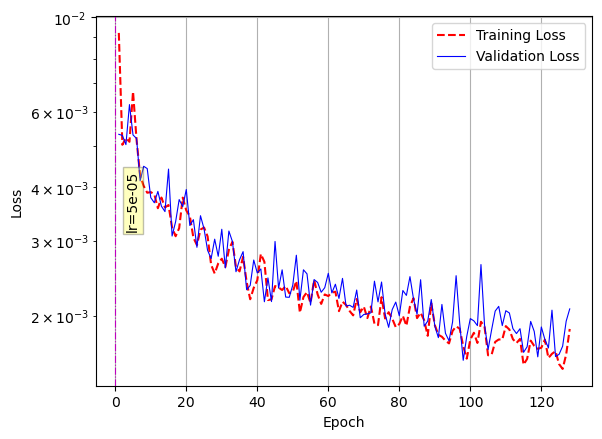

<Figure size 640x480 with 0 Axes>

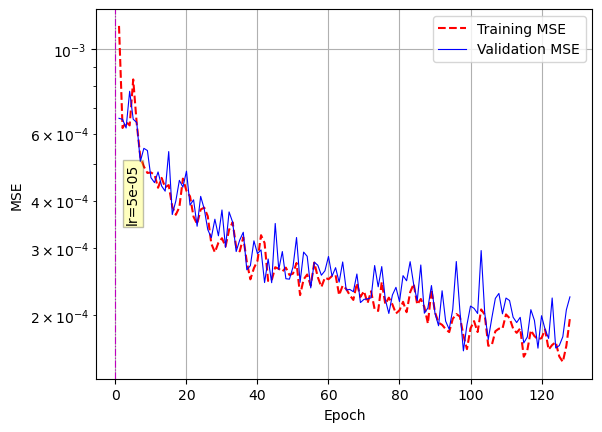

<Figure size 640x480 with 0 Axes>

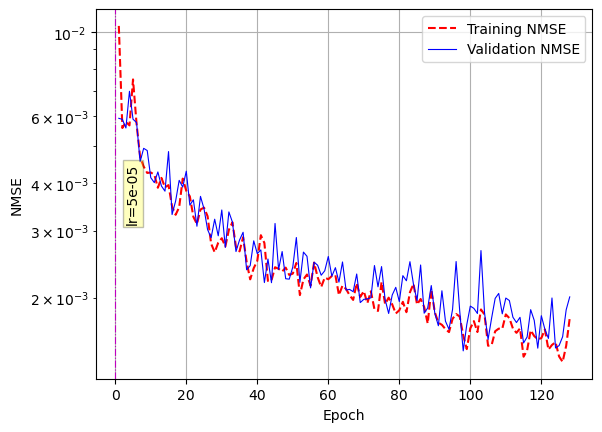

<Figure size 640x480 with 0 Axes>

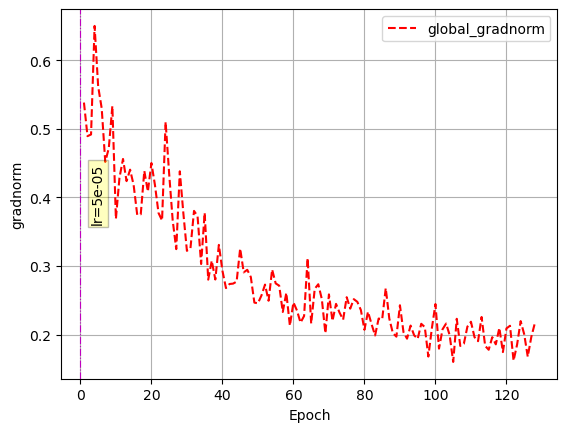



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 30 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.617659318447113


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
58/58 [==============================] - ETA: 0s - loss: 0.0051 - mse: 8.1669e-04 - NMSE: 0.0074 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.6177 - tot_time: 0h 2m 10.5s

Epoch 1: val_NMSE improved from inf to 0.00554, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/checkpoint-30_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

58/58 [==============================] - ETA: 0s - loss: 0.0035 - mse: 5.5239e-04 - NMSE: 0.0050 - covmat_fro_loss: 9.2377e-04 - global_gradnorm: 0.6177 - tot_time: 0h 8m 38.7s

Epoch 11: val_NMSE did not improve from 0.00501
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 39s 669ms/step - loss: 0.0035 - mse: 5.5239e-04 - NMSE: 0.0050 - covmat_fro_loss: 9.2303e-04 - global_gradnorm: 0.6177 - val_loss: 0.0037 - val_mse: 5.7691e-04 - val_NMSE: 0.0052 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/1000
58/58 [==============================] - ETA: 0s - loss: 0.0037 - mse: 5.7344e-04 - NMSE: 0.0052 - covmat_fro_loss: 9.3873e-04 - global_gradnorm: 0.6177 - tot_time: 0h 9m 17.4s

Epoch 12: val_NMSE did not improve from 0.00501
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/

Epoch 23/1000
58/58 [==============================] - ETA: 0s - loss: 0.0032 - mse: 4.9286e-04 - NMSE: 0.0044 - covmat_fro_loss: 8.7738e-04 - global_gradnorm: 0.6177 - tot_time: 0h 16m 26.7s

Epoch 23: val_NMSE did not improve from 0.00471
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 38s 661ms/step - loss: 0.0032 - mse: 4.9286e-04 - NMSE: 0.0044 - covmat_fro_loss: 8.7720e-04 - global_gradnorm: 0.6177 - val_loss: 0.0036 - val_mse: 5.6773e-04 - val_NMSE: 0.0051 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 24/1000
58/58 [==============================] - ETA: 0s - loss: 0.0032 - mse: 4.8895e-04 - NMSE: 0.0044 - covmat_fro_loss: 8.7592e-04 - global_gradnorm: 0.6177 - tot_time: 0h 17m 5.3s

Epoch 24: val_NMSE did not improve from 0.00471
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_

Epoch 35/1000
58/58 [==============================] - ETA: 0s - loss: 0.0031 - mse: 4.7992e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.6830e-04 - global_gradnorm: 0.6177 - tot_time: 0h 24m 11.5s

Epoch 35: val_NMSE did not improve from 0.00457
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 39s 671ms/step - loss: 0.0031 - mse: 4.7992e-04 - NMSE: 0.0043 - covmat_fro_loss: 8.6838e-04 - global_gradnorm: 0.6177 - val_loss: 0.0035 - val_mse: 5.4648e-04 - val_NMSE: 0.0049 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 36/1000
58/58 [==============================] - ETA: 0s - loss: 0.0030 - mse: 4.6408e-04 - NMSE: 0.0042 - covmat_fro_loss: 8.5595e-04 - global_gradnorm: 0.6177 - tot_time: 0h 24m 50.4s

Epoch 36: val_NMSE did not improve from 0.00457
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

Epoch 47/1000
58/58 [==============================] - ETA: 0s - loss: 0.0028 - mse: 4.2824e-04 - NMSE: 0.0039 - covmat_fro_loss: 8.2511e-04 - global_gradnorm: 0.6177 - tot_time: 0h 31m 55.7s

Epoch 47: val_NMSE did not improve from 0.00445
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 39s 668ms/step - loss: 0.0028 - mse: 4.2824e-04 - NMSE: 0.0039 - covmat_fro_loss: 8.2502e-04 - global_gradnorm: 0.6177 - val_loss: 0.0035 - val_mse: 5.3974e-04 - val_NMSE: 0.0049 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 48/1000
58/58 [==============================] - ETA: 0s - loss: 0.0029 - mse: 4.3948e-04 - NMSE: 0.0040 - covmat_fro_loss: 8.3373e-04 - global_gradnorm: 0.6177 - tot_time: 0h 32m 34.3s

Epoch 48: val_NMSE did not improve from 0.00445
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

Epoch 59/1000
58/58 [==============================] - ETA: 0s - loss: 0.0027 - mse: 4.1201e-04 - NMSE: 0.0037 - covmat_fro_loss: 8.0901e-04 - global_gradnorm: 0.6177 - tot_time: 0h 39m 39.8s

Epoch 59: val_NMSE did not improve from 0.00381
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 38s 665ms/step - loss: 0.0027 - mse: 4.1201e-04 - NMSE: 0.0037 - covmat_fro_loss: 8.0819e-04 - global_gradnorm: 0.6177 - val_loss: 0.0031 - val_mse: 4.7965e-04 - val_NMSE: 0.0043 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 60/1000
58/58 [==============================] - ETA: 0s - loss: 0.0027 - mse: 4.0928e-04 - NMSE: 0.0037 - covmat_fro_loss: 8.0859e-04 - global_gradnorm: 0.6177 - tot_time: 0h 40m 18.2s

Epoch 60: val_NMSE did not improve from 0.00381
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN

58/58 [==============================] - ETA: 0s - loss: 0.0028 - mse: 4.2245e-04 - NMSE: 0.0038 - covmat_fro_loss: 8.1867e-04 - global_gradnorm: 0.6177 - tot_time: 0h 47m 23.9s

Epoch 71: val_NMSE did not improve from 0.00381
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 39s 672ms/step - loss: 0.0028 - mse: 4.2245e-04 - NMSE: 0.0038 - covmat_fro_loss: 8.1758e-04 - global_gradnorm: 0.6177 - val_loss: 0.0033 - val_mse: 5.1205e-04 - val_NMSE: 0.0046 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 72/1000
58/58 [==============================] - ETA: 0s - loss: 0.0027 - mse: 4.0262e-04 - NMSE: 0.0036 - covmat_fro_loss: 8.0398e-04 - global_gradnorm: 0.6177 - tot_time: 0h 48m 2.8s

Epoch 72: val_NMSE did not improve from 0.00381
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039

Epoch 83/1000
58/58 [==============================] - ETA: 0s - loss: 0.0025 - mse: 3.6906e-04 - NMSE: 0.0033 - covmat_fro_loss: 7.6842e-04 - global_gradnorm: 0.6175 - tot_time: 0h 55m 8.3s

Epoch 83: val_NMSE did not improve from 0.00348
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 38s 664ms/step - loss: 0.0025 - mse: 3.6906e-04 - NMSE: 0.0033 - covmat_fro_loss: 7.6720e-04 - global_gradnorm: 0.6175 - val_loss: 0.0030 - val_mse: 4.5939e-04 - val_NMSE: 0.0041 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 84/1000
58/58 [==============================] - ETA: 0s - loss: 0.0026 - mse: 3.9209e-04 - NMSE: 0.0035 - covmat_fro_loss: 7.8977e-04 - global_gradnorm: 0.6177 - tot_time: 0h 55m 46.9s

Epoch 84: val_NMSE did not improve from 0.00348
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_

58/58 [==============================] - ETA: 0s - loss: 0.0025 - mse: 3.6963e-04 - NMSE: 0.0033 - covmat_fro_loss: 7.7122e-04 - global_gradnorm: 0.6173 - tot_time: 1h 2m 52.5s

Epoch 95: val_NMSE did not improve from 0.00348
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 39s 666ms/step - loss: 0.0025 - mse: 3.6963e-04 - NMSE: 0.0033 - covmat_fro_loss: 7.7054e-04 - global_gradnorm: 0.6173 - val_loss: 0.0034 - val_mse: 5.2104e-04 - val_NMSE: 0.0047 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 96/1000
58/58 [==============================] - ETA: 0s - loss: 0.0026 - mse: 3.8160e-04 - NMSE: 0.0034 - covmat_fro_loss: 7.8236e-04 - global_gradnorm: 0.6174 - tot_time: 1h 3m 31.1s

Epoch 96: val_NMSE did not improve from 0.00348
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/

58/58 [==============================] - ETA: 0s - loss: 0.0025 - mse: 3.6540e-04 - NMSE: 0.0033 - covmat_fro_loss: 7.6462e-04 - global_gradnorm: 0.6172 - tot_time: 1h 10m 36.3s

Epoch 107: val_NMSE did not improve from 0.00348
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 39s 672ms/step - loss: 0.0025 - mse: 3.6540e-04 - NMSE: 0.0033 - covmat_fro_loss: 7.6456e-04 - global_gradnorm: 0.6172 - val_loss: 0.0032 - val_mse: 4.8488e-04 - val_NMSE: 0.0044 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 108/1000
58/58 [==============================] - ETA: 0s - loss: 0.0024 - mse: 3.5805e-04 - NMSE: 0.0032 - covmat_fro_loss: 7.5913e-04 - global_gradnorm: 0.6174 - tot_time: 1h 11m 14.9s

Epoch 108: val_NMSE did not improve from 0.00348
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

<Figure size 640x480 with 0 Axes>

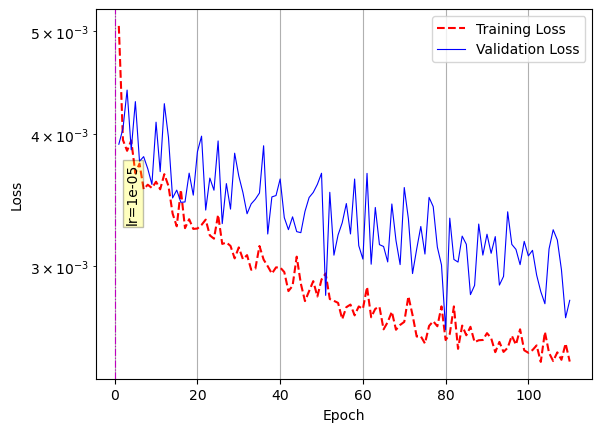

<Figure size 640x480 with 0 Axes>

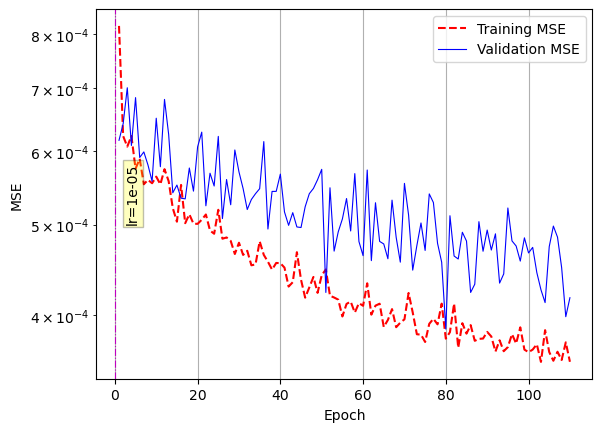

<Figure size 640x480 with 0 Axes>

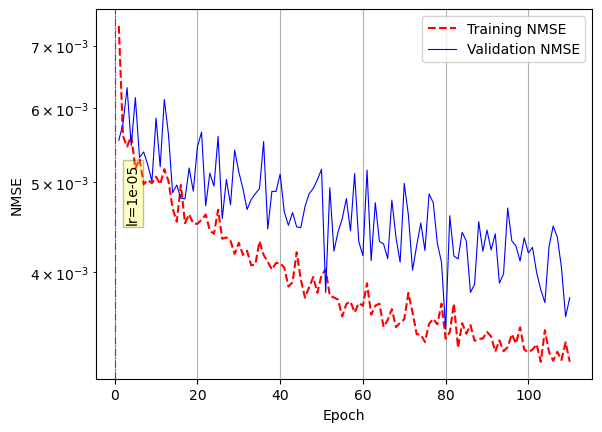

<Figure size 640x480 with 0 Axes>

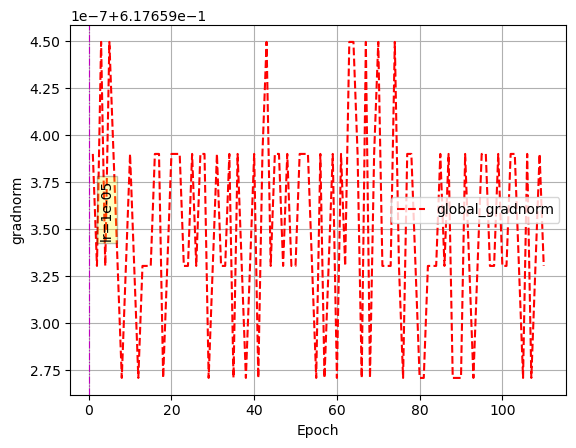



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 50 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 0.5867764770984649


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
98/98 [==============================] - ETA: 0s - loss: 0.0043 - mse: 9.2629e-04 - NMSE: 0.0083 - covmat_fro_loss: 0.0012 - global_gradnorm: 0.5868 - tot_time: 0h 4m 3.2s

Epoch 1: val_NMSE improved from inf to 0.00934, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/checkpoint-50_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

Epoch 12/1000
98/98 [==============================] - ETA: 0s - loss: 0.0035 - mse: 7.2798e-04 - NMSE: 0.0066 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.5868 - tot_time: 0h 20m 22.0s

Epoch 12: val_NMSE did not improve from 0.00831
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 89s 906ms/step - loss: 0.0035 - mse: 7.2798e-04 - NMSE: 0.0066 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.5868 - val_loss: 0.0045 - val_mse: 9.5895e-04 - val_NMSE: 0.0086 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 13/1000
98/98 [==============================] - ETA: 0s - loss: 0.0035 - mse: 7.1685e-04 - NMSE: 0.0065 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.5868 - tot_time: 0h 21m 51.0s

Epoch 13: val_NMSE did not improve from 0.00831
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 87s 893ms/step - loss: 0.0033 - mse: 6.7628e-04 - NMSE: 0.0061 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.5868 - val_loss: 0.0046 - val_mse: 9.8836e-04 - val_NMSE: 0.0089 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 25/1000
98/98 [==============================] - ETA: 0s - loss: 0.0034 - mse: 6.9682e-04 - NMSE: 0.0063 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.5868 - tot_time: 0h 39m 33.1s

Epoch 25: val_NMSE did not improve from 0.00831
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 87s 892ms/step - loss: 0.0034 - mse: 6.9682e-04 - NMSE: 0.0063 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.5868 - val_loss: 0.0045 - val_mse:

Epoch 37/1000
98/98 [==============================] - ETA: 0s - loss: 0.0032 - mse: 6.4321e-04 - NMSE: 0.0058 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.5868 - tot_time: 0h 57m 7.4s

Epoch 37: val_NMSE did not improve from 0.00825
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 88s 895ms/step - loss: 0.0032 - mse: 6.4321e-04 - NMSE: 0.0058 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.5868 - val_loss: 0.0044 - val_mse: 9.3751e-04 - val_NMSE: 0.0084 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 38/1000
98/98 [==============================] - ETA: 0s - loss: 0.0032 - mse: 6.3623e-04 - NMSE: 0.0057 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.5868 - tot_time: 0h 58m 35.0s

Epoch 38: val_NMSE did not improve from 0.00825
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

Epoch 49/1000
98/98 [==============================] - ETA: 0s - loss: 0.0031 - mse: 6.1148e-04 - NMSE: 0.0055 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.5868 - tot_time: 1h 14m 37.5s

Epoch 49: val_NMSE did not improve from 0.00786
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 87s 889ms/step - loss: 0.0031 - mse: 6.1148e-04 - NMSE: 0.0055 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.5868 - val_loss: 0.0044 - val_mse: 9.4691e-04 - val_NMSE: 0.0085 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 50/1000
98/98 [==============================] - ETA: 0s - loss: 0.0031 - mse: 6.2328e-04 - NMSE: 0.0056 - covmat_fro_loss: 0.0011 - global_gradnorm: 0.5868 - tot_time: 1h 16m 4.7s

Epoch 50: val_NMSE did not improve from 0.00786
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

98/98 [==============================] - ETA: 0s - loss: 0.0030 - mse: 6.0128e-04 - NMSE: 0.0054 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.5868 - tot_time: 1h 32m 6.2s

Epoch 61: val_NMSE did not improve from 0.00782
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 89s 906ms/step - loss: 0.0030 - mse: 6.0128e-04 - NMSE: 0.0054 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.5868 - val_loss: 0.0044 - val_mse: 9.4189e-04 - val_NMSE: 0.0085 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 62/1000
98/98 [==============================] - ETA: 0s - loss: 0.0030 - mse: 5.8843e-04 - NMSE: 0.0053 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.5868 - tot_time: 1h 33m 34.6s

Epoch 62: val_NMSE did not improve from 0.00782
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 89s 907ms/step - loss: 0.0029 - mse: 5.7533e-04 - NMSE: 0.0052 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.5868 - val_loss: 0.0042 - val_mse: 8.9573e-04 - val_NMSE: 0.0081 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 74/1000
98/98 [==============================] - ETA: 0s - loss: 0.0029 - mse: 5.7099e-04 - NMSE: 0.0051 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.5868 - tot_time: 1h 51m 18.6s

Epoch 74: val_NMSE did not improve from 0.00782
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 90s 917ms/step - loss: 0.0029 - mse: 5.7099e-04 - NMSE: 0.0051 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.5868 - val_loss: 0.0045 - val_mse:

Epoch 86/1000
98/98 [==============================] - ETA: 0s - loss: 0.0029 - mse: 5.6457e-04 - NMSE: 0.0051 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.5868 - tot_time: 2h 9m 12.7s

Epoch 86: val_NMSE did not improve from 0.00782
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 89s 907ms/step - loss: 0.0029 - mse: 5.6457e-04 - NMSE: 0.0051 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.5868 - val_loss: 0.0044 - val_mse: 9.3011e-04 - val_NMSE: 0.0084 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 87/1000
98/98 [==============================] - ETA: 0s - loss: 0.0029 - mse: 5.7310e-04 - NMSE: 0.0052 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.5868 - tot_time: 2h 10m 41.6s

Epoch 87: val_NMSE did not improve from 0.00782
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 88s 895ms/step - loss: 0.0028 - mse: 5.4413e-04 - NMSE: 0.0049 - covmat_fro_loss: 9.9523e-04 - global_gradnorm: 0.5868 - val_loss: 0.0042 - val_mse: 8.9191e-04 - val_NMSE: 0.0080 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 99/1000
98/98 [==============================] - ETA: 0s - loss: 0.0028 - mse: 5.5161e-04 - NMSE: 0.0050 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.5868 - tot_time: 2h 28m 29.5s

Epoch 99: val_NMSE did not improve from 0.00782
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 88s 898ms/step - loss: 0.0028 - mse: 5.5161e-04 - NMSE: 0.0050 - covmat_fro_loss: 0.0010 - global_gradnorm: 0.5868 - val_loss: 0.0041 - val_

98/98 [==============================] - ETA: 0s - loss: 0.0028 - mse: 5.3805e-04 - NMSE: 0.0048 - covmat_fro_loss: 9.9756e-04 - global_gradnorm: 0.5868 - tot_time: 2h 44m 36.3s

Epoch 110: val_NMSE did not improve from 0.00761
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 88s 895ms/step - loss: 0.0028 - mse: 5.3805e-04 - NMSE: 0.0048 - covmat_fro_loss: 9.9643e-04 - global_gradnorm: 0.5868 - val_loss: 0.0043 - val_mse: 9.0187e-04 - val_NMSE: 0.0081 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 111/1000
98/98 [==============================] - ETA: 0s - loss: 0.0028 - mse: 5.3828e-04 - NMSE: 0.0048 - covmat_fro_loss: 9.9376e-04 - global_gradnorm: 0.5868 - tot_time: 2h 46m 3.7s

Epoch 111: val_NMSE improved from 0.00761 to 0.00759, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/che

Epoch 122/1000
98/98 [==============================] - ETA: 0s - loss: 0.0027 - mse: 5.3097e-04 - NMSE: 0.0048 - covmat_fro_loss: 9.8604e-04 - global_gradnorm: 0.5868 - tot_time: 3h 2m 18.4s

Epoch 122: val_NMSE did not improve from 0.00759
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 90s 917ms/step - loss: 0.0027 - mse: 5.3097e-04 - NMSE: 0.0048 - covmat_fro_loss: 9.8510e-04 - global_gradnorm: 0.5868 - val_loss: 0.0041 - val_mse: 8.5550e-04 - val_NMSE: 0.0077 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 123/1000
98/98 [==============================] - ETA: 0s - loss: 0.0027 - mse: 5.2823e-04 - NMSE: 0.0048 - covmat_fro_loss: 9.9044e-04 - global_gradnorm: 0.5868 - tot_time: 3h 3m 47.6s

Epoch 123: val_NMSE did not improve from 0.00759
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AER

98/98 [==============================] - ETA: 0s - loss: 0.0027 - mse: 5.1566e-04 - NMSE: 0.0046 - covmat_fro_loss: 9.7699e-04 - global_gradnorm: 0.5868 - tot_time: 3h 20m 4.8s

Epoch 134: val_NMSE did not improve from 0.00759
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 88s 895ms/step - loss: 0.0027 - mse: 5.1566e-04 - NMSE: 0.0046 - covmat_fro_loss: 9.7602e-04 - global_gradnorm: 0.5868 - val_loss: 0.0041 - val_mse: 8.7642e-04 - val_NMSE: 0.0079 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 135/1000
98/98 [==============================] - ETA: 0s - loss: 0.0027 - mse: 5.1702e-04 - NMSE: 0.0047 - covmat_fro_loss: 9.7773e-04 - global_gradnorm: 0.5868 - tot_time: 3h 21m 32.5s

Epoch 135: val_NMSE did not improve from 0.00759
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_

Epoch 146/1000
98/98 [==============================] - ETA: 0s - loss: 0.0026 - mse: 5.0583e-04 - NMSE: 0.0046 - covmat_fro_loss: 9.6780e-04 - global_gradnorm: 0.5868 - tot_time: 3h 37m 37.1s

Epoch 146: val_NMSE did not improve from 0.00753
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 87s 892ms/step - loss: 0.0026 - mse: 5.0583e-04 - NMSE: 0.0046 - covmat_fro_loss: 9.6705e-04 - global_gradnorm: 0.5868 - val_loss: 0.0040 - val_mse: 8.5002e-04 - val_NMSE: 0.0077 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 147/1000
98/98 [==============================] - ETA: 0s - loss: 0.0026 - mse: 5.0188e-04 - NMSE: 0.0045 - covmat_fro_loss: 9.6591e-04 - global_gradnorm: 0.5868 - tot_time: 3h 39m 4.2s

Epoch 147: val_NMSE did not improve from 0.00753
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AE

98/98 [==============================] - ETA: 0s - loss: 0.0026 - mse: 4.9702e-04 - NMSE: 0.0045 - covmat_fro_loss: 9.6240e-04 - global_gradnorm: 0.5868 - tot_time: 3h 55m 3.5s

Epoch 158: val_NMSE did not improve from 0.00753
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 87s 889ms/step - loss: 0.0026 - mse: 4.9702e-04 - NMSE: 0.0045 - covmat_fro_loss: 9.6150e-04 - global_gradnorm: 0.5868 - val_loss: 0.0042 - val_mse: 8.9579e-04 - val_NMSE: 0.0081 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 159/1000
98/98 [==============================] - ETA: 0s - loss: 0.0026 - mse: 4.9893e-04 - NMSE: 0.0045 - covmat_fro_loss: 9.6520e-04 - global_gradnorm: 0.5868 - tot_time: 3h 56m 30.7s

Epoch 159: val_NMSE did not improve from 0.00753
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_

Epoch 170/1000
98/98 [==============================] - ETA: 0s - loss: 0.0026 - mse: 4.9721e-04 - NMSE: 0.0045 - covmat_fro_loss: 9.6367e-04 - global_gradnorm: 0.5868 - tot_time: 4h 12m 33.9s

Epoch 170: val_NMSE did not improve from 0.00753
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 88s 896ms/step - loss: 0.0026 - mse: 4.9721e-04 - NMSE: 0.0045 - covmat_fro_loss: 9.6389e-04 - global_gradnorm: 0.5868 - val_loss: 0.0042 - val_mse: 9.0317e-04 - val_NMSE: 0.0081 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 171/1000
98/98 [==============================] - ETA: 0s - loss: 0.0026 - mse: 4.9348e-04 - NMSE: 0.0044 - covmat_fro_loss: 9.6150e-04 - global_gradnorm: 0.5868 - tot_time: 4h 14m 1.4s

Epoch 171: val_NMSE did not improve from 0.00753
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AE

Epoch 182/1000
98/98 [==============================] - ETA: 0s - loss: 0.0025 - mse: 4.8720e-04 - NMSE: 0.0044 - covmat_fro_loss: 9.5537e-04 - global_gradnorm: 0.5868 - tot_time: 4h 30m 5.3s

Epoch 182: val_NMSE did not improve from 0.00739
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 88s 894ms/step - loss: 0.0025 - mse: 4.8720e-04 - NMSE: 0.0044 - covmat_fro_loss: 9.5461e-04 - global_gradnorm: 0.5868 - val_loss: 0.0042 - val_mse: 8.8152e-04 - val_NMSE: 0.0079 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 183/1000
98/98 [==============================] - ETA: 0s - loss: 0.0025 - mse: 4.8712e-04 - NMSE: 0.0044 - covmat_fro_loss: 9.5664e-04 - global_gradnorm: 0.5868 - tot_time: 4h 31m 33.2s

Epoch 183: val_NMSE did not improve from 0.00739
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AE

98/98 [==============================] - ETA: 0s - loss: 0.0025 - mse: 4.7640e-04 - NMSE: 0.0043 - covmat_fro_loss: 9.4577e-04 - global_gradnorm: 0.5868 - tot_time: 4h 47m 33.0s

Epoch 194: val_NMSE did not improve from 0.00739
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 87s 892ms/step - loss: 0.0025 - mse: 4.7640e-04 - NMSE: 0.0043 - covmat_fro_loss: 9.4597e-04 - global_gradnorm: 0.5868 - val_loss: 0.0040 - val_mse: 8.3707e-04 - val_NMSE: 0.0075 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 195/1000
98/98 [==============================] - ETA: 0s - loss: 0.0025 - mse: 4.7732e-04 - NMSE: 0.0043 - covmat_fro_loss: 9.4775e-04 - global_gradnorm: 0.5868 - tot_time: 4h 49m 0.3s

Epoch 195: val_NMSE did not improve from 0.00739
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_

Epoch 206/1000
98/98 [==============================] - ETA: 0s - loss: 0.0025 - mse: 4.7019e-04 - NMSE: 0.0042 - covmat_fro_loss: 9.3936e-04 - global_gradnorm: 0.5868 - tot_time: 5h 5m 2.7s

Epoch 206: val_NMSE did not improve from 0.00727
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 87s 889ms/step - loss: 0.0025 - mse: 4.7019e-04 - NMSE: 0.0042 - covmat_fro_loss: 9.3907e-04 - global_gradnorm: 0.5868 - val_loss: 0.0039 - val_mse: 8.2460e-04 - val_NMSE: 0.0074 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 207/1000
98/98 [==============================] - ETA: 0s - loss: 0.0025 - mse: 4.7441e-04 - NMSE: 0.0043 - covmat_fro_loss: 9.4380e-04 - global_gradnorm: 0.5868 - tot_time: 5h 6m 30.3s

Epoch 207: val_NMSE did not improve from 0.00727
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

98/98 [==============================] - ETA: 0s - loss: 0.0025 - mse: 4.7627e-04 - NMSE: 0.0043 - covmat_fro_loss: 9.4510e-04 - global_gradnorm: 0.5868 - tot_time: 5h 22m 29.9s

Epoch 218: val_NMSE did not improve from 0.00727
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 87s 890ms/step - loss: 0.0025 - mse: 4.7627e-04 - NMSE: 0.0043 - covmat_fro_loss: 9.4577e-04 - global_gradnorm: 0.5868 - val_loss: 0.0040 - val_mse: 8.4283e-04 - val_NMSE: 0.0076 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 219/1000
98/98 [==============================] - ETA: 0s - loss: 0.0025 - mse: 4.6902e-04 - NMSE: 0.0042 - covmat_fro_loss: 9.3428e-04 - global_gradnorm: 0.5868 - tot_time: 5h 23m 56.9s

Epoch 219: val_NMSE did not improve from 0.00727
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

Epoch 230/1000
98/98 [==============================] - ETA: 0s - loss: 0.0025 - mse: 4.6644e-04 - NMSE: 0.0042 - covmat_fro_loss: 9.3517e-04 - global_gradnorm: 0.5868 - tot_time: 5h 39m 59.1s

Epoch 230: val_NMSE did not improve from 0.00723
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 88s 897ms/step - loss: 0.0025 - mse: 4.6644e-04 - NMSE: 0.0042 - covmat_fro_loss: 9.3549e-04 - global_gradnorm: 0.5868 - val_loss: 0.0039 - val_mse: 8.2128e-04 - val_NMSE: 0.0074 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 231/1000
98/98 [==============================] - ETA: 0s - loss: 0.0024 - mse: 4.5722e-04 - NMSE: 0.0041 - covmat_fro_loss: 9.2865e-04 - global_gradnorm: 0.5868 - tot_time: 5h 41m 27.2s

Epoch 231: val_NMSE did not improve from 0.00723
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

98/98 [==============================] - ETA: 0s - loss: 0.0024 - mse: 4.6258e-04 - NMSE: 0.0042 - covmat_fro_loss: 9.3339e-04 - global_gradnorm: 0.5868 - tot_time: 5h 57m 31.0s

Epoch 242: val_NMSE did not improve from 0.00723
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 88s 897ms/step - loss: 0.0024 - mse: 4.6258e-04 - NMSE: 0.0042 - covmat_fro_loss: 9.3346e-04 - global_gradnorm: 0.5868 - val_loss: 0.0040 - val_mse: 8.3627e-04 - val_NMSE: 0.0075 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 243/1000
98/98 [==============================] - ETA: 0s - loss: 0.0025 - mse: 4.6492e-04 - NMSE: 0.0042 - covmat_fro_loss: 9.3416e-04 - global_gradnorm: 0.5868 - tot_time: 5h 58m 58.9s

Epoch 243: val_NMSE did not improve from 0.00723
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

98/98 [==============================] - ETA: 0s - loss: 0.0024 - mse: 4.5014e-04 - NMSE: 0.0041 - covmat_fro_loss: 9.1950e-04 - global_gradnorm: 0.5868 - tot_time: 6h 14m 59.7s

Epoch 254: val_NMSE improved from 0.00723 to 0.00718, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/checkpoint-50_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 89s 910ms/step - loss: 0.0024 - mse: 4.5014e-04 - NMSE: 0.0041 - covmat_fro_loss: 9.1840e-04 - global_gradnorm: 0.5868 - val_loss: 0.0038 - val_mse: 7.9815e-04 - val_NMSE: 0.0072 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 255/1000
98/98 [==============================] - ETA: 0s - loss: 0.0024 - mse: 4.4858e-04 - NMSE: 0.0040 - covmat_fro_loss: 9.2197e-04 - global_gradnorm: 0.5868 - tot_time: 6h 16m 29.0s

Epoch 255: val_N

Epoch 266/1000
98/98 [==============================] - ETA: 0s - loss: 0.0023 - mse: 4.3812e-04 - NMSE: 0.0039 - covmat_fro_loss: 9.1056e-04 - global_gradnorm: 0.5868 - tot_time: 6h 32m 33.5s

Epoch 266: val_NMSE did not improve from 0.00718
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 87s 891ms/step - loss: 0.0023 - mse: 4.3812e-04 - NMSE: 0.0039 - covmat_fro_loss: 9.0972e-04 - global_gradnorm: 0.5868 - val_loss: 0.0039 - val_mse: 8.0710e-04 - val_NMSE: 0.0073 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 267/1000
98/98 [==============================] - ETA: 0s - loss: 0.0024 - mse: 4.4679e-04 - NMSE: 0.0040 - covmat_fro_loss: 9.2150e-04 - global_gradnorm: 0.5868 - tot_time: 6h 34m 1.4s

Epoch 267: val_NMSE did not improve from 0.00718
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AE

98/98 [==============================] - ETA: 0s - loss: 0.0024 - mse: 4.4497e-04 - NMSE: 0.0040 - covmat_fro_loss: 9.2049e-04 - global_gradnorm: 0.5868 - tot_time: 6h 50m 2.3s

Epoch 278: val_NMSE did not improve from 0.00718
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 87s 891ms/step - loss: 0.0024 - mse: 4.4497e-04 - NMSE: 0.0040 - covmat_fro_loss: 9.2054e-04 - global_gradnorm: 0.5868 - val_loss: 0.0040 - val_mse: 8.3848e-04 - val_NMSE: 0.0075 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 279/1000
98/98 [==============================] - ETA: 0s - loss: 0.0023 - mse: 4.3471e-04 - NMSE: 0.0039 - covmat_fro_loss: 9.0905e-04 - global_gradnorm: 0.5868 - tot_time: 6h 51m 30.1s

Epoch 279: val_NMSE did not improve from 0.00718
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_

Epoch 290/1000
98/98 [==============================] - ETA: 0s - loss: 0.0023 - mse: 4.3960e-04 - NMSE: 0.0040 - covmat_fro_loss: 9.0965e-04 - global_gradnorm: 0.5868 - tot_time: 7h 7m 33.4s

Epoch 290: val_NMSE did not improve from 0.00714
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 87s 890ms/step - loss: 0.0023 - mse: 4.3960e-04 - NMSE: 0.0040 - covmat_fro_loss: 9.0962e-04 - global_gradnorm: 0.5868 - val_loss: 0.0039 - val_mse: 8.2607e-04 - val_NMSE: 0.0074 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 291/1000
98/98 [==============================] - ETA: 0s - loss: 0.0024 - mse: 4.4116e-04 - NMSE: 0.0040 - covmat_fro_loss: 9.1441e-04 - global_gradnorm: 0.5868 - tot_time: 7h 9m 1.3s

Epoch 291: val_NMSE did not improve from 0.00714
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERN

Epoch 302/1000
98/98 [==============================] - ETA: 0s - loss: 0.0023 - mse: 4.2924e-04 - NMSE: 0.0039 - covmat_fro_loss: 9.0323e-04 - global_gradnorm: 0.5868 - tot_time: 7h 25m 15.0s

Epoch 302: val_NMSE did not improve from 0.00714
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 89s 906ms/step - loss: 0.0023 - mse: 4.2924e-04 - NMSE: 0.0039 - covmat_fro_loss: 9.0313e-04 - global_gradnorm: 0.5868 - val_loss: 0.0039 - val_mse: 8.0985e-04 - val_NMSE: 0.0073 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 303/1000
98/98 [==============================] - ETA: 0s - loss: 0.0023 - mse: 4.3036e-04 - NMSE: 0.0039 - covmat_fro_loss: 9.0436e-04 - global_gradnorm: 0.5868 - tot_time: 7h 26m 43.8s

Epoch 303: val_NMSE did not improve from 0.00714
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

Epoch 314/1000
98/98 [==============================] - ETA: 0s - loss: 0.0023 - mse: 4.3032e-04 - NMSE: 0.0039 - covmat_fro_loss: 9.0585e-04 - global_gradnorm: 0.5868 - tot_time: 7h 43m 2.7s

Epoch 314: val_NMSE did not improve from 0.00707
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 89s 908ms/step - loss: 0.0023 - mse: 4.3032e-04 - NMSE: 0.0039 - covmat_fro_loss: 9.0572e-04 - global_gradnorm: 0.5868 - val_loss: 0.0038 - val_mse: 8.0267e-04 - val_NMSE: 0.0072 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 315/1000
98/98 [==============================] - ETA: 0s - loss: 0.0023 - mse: 4.2894e-04 - NMSE: 0.0039 - covmat_fro_loss: 9.0367e-04 - global_gradnorm: 0.5868 - tot_time: 7h 44m 31.6s

Epoch 315: val_NMSE did not improve from 0.00707
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AE

98/98 [==============================] - ETA: 0s - loss: 0.0023 - mse: 4.2729e-04 - NMSE: 0.0038 - covmat_fro_loss: 8.9828e-04 - global_gradnorm: 0.5868 - tot_time: 8h 0m 50.1s

Epoch 326: val_NMSE did not improve from 0.00707
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 89s 908ms/step - loss: 0.0023 - mse: 4.2729e-04 - NMSE: 0.0038 - covmat_fro_loss: 8.9728e-04 - global_gradnorm: 0.5868 - val_loss: 0.0040 - val_mse: 8.4467e-04 - val_NMSE: 0.0076 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 327/1000
98/98 [==============================] - ETA: 0s - loss: 0.0023 - mse: 4.2138e-04 - NMSE: 0.0038 - covmat_fro_loss: 8.9934e-04 - global_gradnorm: 0.5868 - tot_time: 8h 2m 19.4s

Epoch 327: val_NMSE did not improve from 0.00707
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_0

Epoch 338/1000
98/98 [==============================] - ETA: 0s - loss: 0.0023 - mse: 4.2115e-04 - NMSE: 0.0038 - covmat_fro_loss: 8.9478e-04 - global_gradnorm: 0.5868 - tot_time: 8h 18m 37.8s

Epoch 338: val_NMSE did not improve from 0.00707
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 89s 907ms/step - loss: 0.0023 - mse: 4.2115e-04 - NMSE: 0.0038 - covmat_fro_loss: 8.9570e-04 - global_gradnorm: 0.5868 - val_loss: 0.0038 - val_mse: 8.0355e-04 - val_NMSE: 0.0072 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 339/1000
98/98 [==============================] - ETA: 0s - loss: 0.0023 - mse: 4.1979e-04 - NMSE: 0.0038 - covmat_fro_loss: 8.9671e-04 - global_gradnorm: 0.5868 - tot_time: 8h 20m 6.6s

Epoch 339: val_NMSE did not improve from 0.00707
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AE

Epoch 350/1000
98/98 [==============================] - ETA: 0s - loss: 0.0023 - mse: 4.2128e-04 - NMSE: 0.0038 - covmat_fro_loss: 8.9550e-04 - global_gradnorm: 0.5868 - tot_time: 8h 36m 24.1s

Epoch 350: val_NMSE did not improve from 0.00683
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 88s 903ms/step - loss: 0.0023 - mse: 4.2128e-04 - NMSE: 0.0038 - covmat_fro_loss: 8.9527e-04 - global_gradnorm: 0.5868 - val_loss: 0.0039 - val_mse: 8.2083e-04 - val_NMSE: 0.0074 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 351/1000
98/98 [==============================] - ETA: 0s - loss: 0.0022 - mse: 4.0781e-04 - NMSE: 0.0037 - covmat_fro_loss: 8.8836e-04 - global_gradnorm: 0.5868 - tot_time: 8h 37m 53.1s

Epoch 351: val_NMSE did not improve from 0.00683
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_A

98/98 [==============================] - ETA: 0s - loss: 0.0023 - mse: 4.1761e-04 - NMSE: 0.0038 - covmat_fro_loss: 8.9454e-04 - global_gradnorm: 0.5868 - tot_time: 8h 54m 12.3s

Epoch 362: val_NMSE did not improve from 0.00683
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 89s 909ms/step - loss: 0.0023 - mse: 4.1761e-04 - NMSE: 0.0038 - covmat_fro_loss: 8.9447e-04 - global_gradnorm: 0.5868 - val_loss: 0.0037 - val_mse: 7.7405e-04 - val_NMSE: 0.0070 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 363/1000
98/98 [==============================] - ETA: 0s - loss: 0.0022 - mse: 4.1161e-04 - NMSE: 0.0037 - covmat_fro_loss: 8.9082e-04 - global_gradnorm: 0.5868 - tot_time: 8h 55m 41.2s

Epoch 363: val_NMSE did not improve from 0.00683
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

98/98 [==============================] - ETA: 0s - loss: 0.0022 - mse: 4.0348e-04 - NMSE: 0.0036 - covmat_fro_loss: 8.8074e-04 - global_gradnorm: 0.5868 - tot_time: 9h 12m 0.2s

Epoch 374: val_NMSE did not improve from 0.00683
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 90s 916ms/step - loss: 0.0022 - mse: 4.0348e-04 - NMSE: 0.0036 - covmat_fro_loss: 8.8089e-04 - global_gradnorm: 0.5868 - val_loss: 0.0038 - val_mse: 7.9757e-04 - val_NMSE: 0.0072 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 375/1000
98/98 [==============================] - ETA: 0s - loss: 0.0022 - mse: 4.0518e-04 - NMSE: 0.0036 - covmat_fro_loss: 8.8106e-04 - global_gradnorm: 0.5868 - tot_time: 9h 13m 29.3s

Epoch 375: val_NMSE did not improve from 0.00683
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_

98/98 [==============================] - ETA: 0s - loss: 0.0022 - mse: 4.0300e-04 - NMSE: 0.0036 - covmat_fro_loss: 8.8206e-04 - global_gradnorm: 0.5868 - tot_time: 9h 29m 47.0s

Epoch 386: val_NMSE did not improve from 0.00683
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 89s 904ms/step - loss: 0.0022 - mse: 4.0300e-04 - NMSE: 0.0036 - covmat_fro_loss: 8.8216e-04 - global_gradnorm: 0.5868 - val_loss: 0.0039 - val_mse: 8.0903e-04 - val_NMSE: 0.0073 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 387/1000
98/98 [==============================] - ETA: 0s - loss: 0.0022 - mse: 4.0645e-04 - NMSE: 0.0037 - covmat_fro_loss: 8.8500e-04 - global_gradnorm: 0.5868 - tot_time: 9h 31m 16.2s

Epoch 387: val_NMSE did not improve from 0.00683
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn

98/98 [==============================] - ETA: 0s - loss: 0.0022 - mse: 4.0617e-04 - NMSE: 0.0037 - covmat_fro_loss: 8.8304e-04 - global_gradnorm: 0.5868Restoring model weights from the end of the best epoch: 348.
 - tot_time: 9h 47m 33.4s

Epoch 398: val_NMSE did not improve from 0.00683
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_AR_AERNN_rnn/AR_rnn_039/checkpoints/LossHistoriesCheckpoint-50_outsteps
98/98 [==============================] - 89s 912ms/step - loss: 0.0022 - mse: 4.0617e-04 - NMSE: 0.0037 - covmat_fro_loss: 8.8274e-04 - global_gradnorm: 0.5868 - val_loss: 0.0039 - val_mse: 8.0826e-04 - val_NMSE: 0.0073 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 398: early stopping


<Figure size 640x480 with 0 Axes>

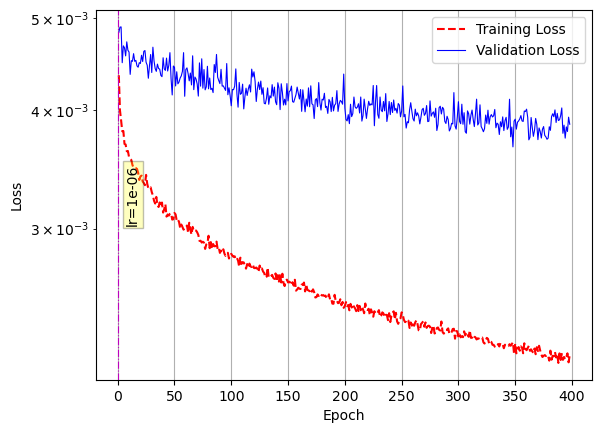

<Figure size 640x480 with 0 Axes>

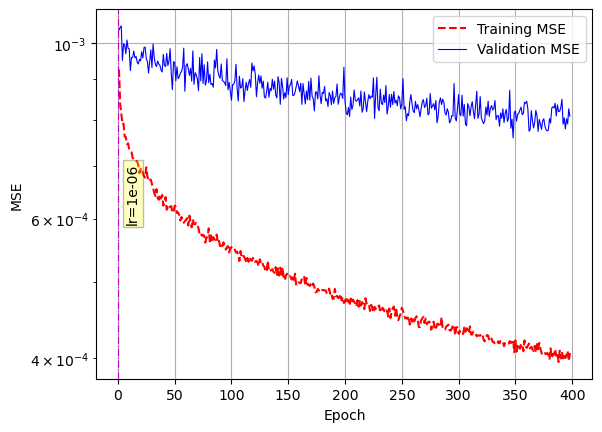

<Figure size 640x480 with 0 Axes>

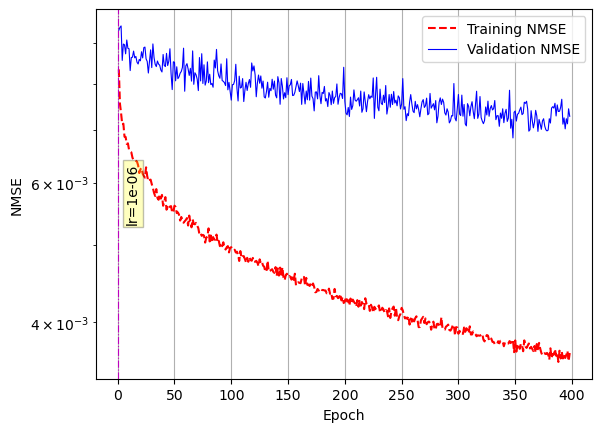

<Figure size 640x480 with 0 Axes>

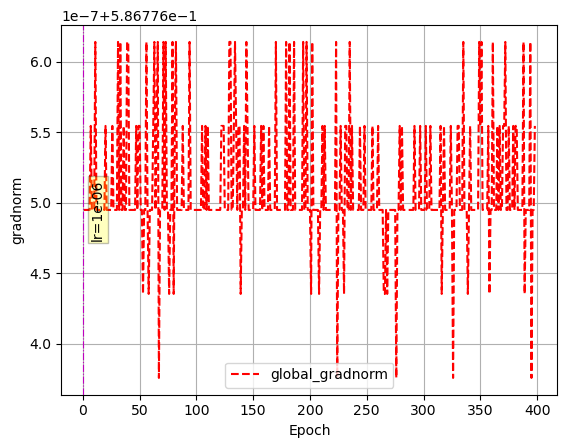

<Figure size 640x480 with 0 Axes>

In [21]:
global_clipnorm = None
for kk in range(len(T_sample_output)):

    num_outsteps = int((T_sample_output[kk] + 0.5*dt_rnn)//dt_rnn)
    if type(freeze_layers) == type(None):
        freeze_layers_thisoutstep = []
    else:
        if kk > len(freeze_layers) - 1:
            freeze_layers_thisoutstep = freeze_layers[-1]
        else:
            freeze_layers_thisoutstep = freeze_layers[kk]
        
        if type(freeze_layers_thisoutstep) == type(None):
            freeze_layers_thisoutstep = []
            
    if type(batch_size) == type([]):
        if kk > len(batch_size) - 1:
            batch_size_thisoutstep = batch_size[-1]
        else:
            batch_size_thisoutstep = batch_size[kk]
    else:
        batch_size_thisoutstep = batch_size

    total_s_len = 80
    sep_lr_s = ' num_outsteps : {} '.format(num_outsteps)
    sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'>' + sep_lr_s
    sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'<'
    print('\n\n' + '*'*len(sep_lr_s))
    print('' + sep_lr_s+'')
    print('*'*len(sep_lr_s) + '\n\n')

    print('clipnorm : {}, global_clipnorm : {}'.format(clipnorm, global_clipnorm))
    
    trainAERNN(
        create_data_for_RNN,
        Autoencoder,
        AR_RNN,
        all_data,
        AR_AERNN_GRU,
        dt_rnn=dt_rnn,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output[kk],
        T_offset=T_offset,
        boundary_idx_arr=boundary_idx_arr,
        delta_t=delta_t,
        params=params,
        normalize_dataset=normalize_dataset,
        stddev_multiplier=stddev_multiplier,
        skip_intermediate=skip_intermediate,
        normalization_type=normalization_type,
        normalization_constant_arr_aedata=normalization_constant_arr_aedata,
        normalization_constant_arr_rnndata=normalization_arr_rnn,
        learning_rate_list=learning_rate_list[kk],
        epochs=epochs[kk],
        patience=patience[kk],
        loss_weights=loss_weights,
        min_delta=min_delta,
        lambda_reg=lambda_reg,
        stddev_rnn=stddev,
        stateful=False,
        behaviour=behaviour,
        strategy=strategy,
        dir_name_rnn=dir_name_rnn,
        dir_name_AR_AErnn=dir_name_ARrnn,
        batch_size=batch_size_thisoutstep,
        load_file_rnn=load_file_rnn,
        wt_file_rnn=wt_file_rnn,
        load_file_ae=load_file_ae,
        wt_file_ae=wt_file_ae,
        covmat_lmda=covmat_lmda,
        readAndReturnLossHistories=readAndReturnLossHistories,
        mytimecallback=mytimecallback,
        plot_losses=plot_losses,
        SaveLosses=SaveLosses,
        train_split=train_split,
        test_split=test_split,
        val_split=val_split,
        freeze_layers=freeze_layers_thisoutstep,
        clipnorm=clipnorm,
        global_clipnorm=global_clipnorm,
        use_ae_data=use_ae_data,
    )
    
    wt_file_rnn = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.h5'.format(num_outsteps)
    wt_file_ae = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(num_outsteps)
    
    with open(dir_name_ARrnn+'/final_net/losses-{}_outsteps.txt'.format(num_outsteps), 'r') as fl:
        lines = fl.readlines()

    loss_dict = eval(''.join(lines))
    train_global_gradnorm_hist = loss_dict['train_global_gradnorm_hist']
    # lr_change = loss_dict['lr_change']
    # trained_epochs = len(train_global_gradnorm_hist)
    # if lr_change[-1] - lr_change[-2] == epochs[kk][-1]:
    #     global_clipnorm = train_global_gradnorm_hist[-1]
    # else:
    #     global_clipnorm = train_global_gradnorm_hist[-patience[kk][-1]]

    # alpha1 = 0.9
    # alpha2 = 0.1
    # global_clipnorm = train_global_gradnorm_hist[0]
    # for i in range(1, len(train_global_gradnorm_hist)):
    #     global_clipnorm = alpha1*global_clipnorm + alpha2*train_global_gradnorm_hist[i]

    grad_norm_decay = 0.95
    idxs_to_ignore = 0

    global_clipnorm = np.max(train_global_gradnorm_hist[idxs_to_ignore:])
    # global_clipnorm = 0.25 * np.round(4*global_clipnorm)
    global_clipnorm = grad_norm_decay * global_clipnorm

In [22]:
a = 123e-5
a

0.00123

In [23]:
s = '{:E}'.format(a)
s

'1.230000E-03'

In [24]:
idx = s.find('E')
num = float(s[0:idx])
10**float(s[idx+1:])

0.001

In [25]:
### Training the combined AE-RNN


# 